# How to stream from the final node

A common use case is streaming from an agent is to stream LLM tokens from inside the final node. This guide demonstrates how you can do this.

## Setup

First let's install our required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai langchain-community

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define model and tools

In [2]:
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import ConfigurableField
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import ToolNode


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]
model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
final_model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

model = model.bind_tools(tools)
# NOTE: this is where we're adding a tag that we'll can use later to filter the model stream events to only the model called in the final node.
# This is not necessary if you call a single LLM but might be important in case you call multiple models within the node and want to filter events
# from only one of them.
final_model = final_model.with_config(tags=["final_node"])
tool_node = ToolNode(tools=tools)

## Define graph

In [3]:
from typing import TypedDict, Annotated

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage


def should_continue(state: MessagesState) -> Literal["tools", "final"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "final"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    response = final_model.invoke(
        [
            SystemMessage("Rewrite this in the voice of Al Roker"),
            HumanMessage(last_ai_message.content),
        ]
    )
    # overwrite the last AI message from the agent
    response.id = last_ai_message.id
    return {"messages": [response]}

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
# add a separate final node
workflow.add_node("final", call_final_model)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")
workflow.add_edge("final", END)

app = workflow.compile()

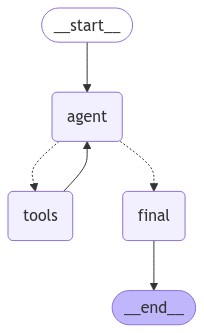

In [4]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

## Stream outputs from the final node

In [5]:
import warnings
from langchain_core._api import LangChainBetaWarning
warnings.filterwarnings('ignore', category=LangChainBetaWarning)

### Filter on event metadata

First option to get the LLM events from within a specific node (`final` node in our case) is to filter on the `langgraph_node` field in the event metadata. This will be sufficient in case you need to stream events from ALL LLM calls inside the node. This means that if you have multiple different LLMs invoked inside the node, this filter will include events from all of them.

In [7]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="what is the weather in sf")]
async for msg, metadata in app.astream({"messages": inputs}, stream_mode="messages"):
    if msg.content and not isinstance(msg,HumanMessage) and metadata['langgraph_node'] == 'final':
        print(msg.content, end="|", flush=True)

Well| folks|,| let| me| tell| you|,| the| weather| in| San| Francisco| is| always| sunny|!| That|'s| right|,| you| can| expect| clear| skies| and| plenty| of| sunshine| when| you|'re| in| the| City| by| the| Bay|.| So| grab| your| sunglasses| and| get| ready| to| enjoy| some| beautiful| weather| in| San| Francisco|!|

### Filter on custom tags

Alternatively, you can add configuration with custom tags to your LLM, like we did in the beginning, by adding `final_model.with_config(tags=["final_node"])`. This will allow us to more precisely filter the events to keep the ones only from this model.

In [8]:
inputs = {"messages": [("human", "what's the weather in nyc?")]}
async for event in app.astream_events(inputs, version="v2"):
    kind = event["event"]
    tags = event.get("tags", [])
    # filter on the custom tag
    if kind == "on_chat_model_stream" and "final_node" in event.get("tags", []):
        data = event["data"]
        if data["chunk"].content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(data["chunk"].content, end="|", flush=True)

Well| folks|,| looks| like| we|'ve| got| some| cloudy| skies| in| the| Big| Apple| today|.| So| grab| your| umbrella| just| in| case|,| and| don|'t| let| those| clouds| rain| on| your| parade|!|